# Building a distributed GIS through collaborations
Your GIS becomes much more powerful if it can connect to other GIS and share content with each other. With distributed collaboration, you can connect and integrate your GIS across a network of participant GIS. Your participants could be either ArcGIS Online organizations or ArcGIS Enterprise instances. The benefit of establishing distributed collaboration is to organize, network, and share content between individuals and across organizations and communities.

During the process of establishing a collaboration, you pick a group that becomes your collaboration workspace. The content you share to that group becomes automatically available to your participants and vice-versa. To learn more about collaborations, [refer here](http://doc.arcgis.com/en/arcgis-online/administer/about-distributed-collaboration.htm).

Creating a collaboration involves a sequence of steps. You can either follow them yourself if you need fine-grained control, or, if you are an administrator on both the host and participant GIS, you can [call the shortcut](#Shortcut-to-establish-collaborations-in-a-single-step) referred in the end of this guide to create a collaboration in one simple step.

 1. [Host GIS creates a collaboration](#Step-1:-Create-a-collaboration). This step involves choosing a workspace and a group intended for sharing content.
 2. [Host GIS invites a participant GIS to the collaboration](#Step-2:-Invite-participant-GIS-to-the-collaboration). This step involves downloading an invitation file and sending it over to the recipient GIS's administrator in a secure manner.
 3. [Guest GIS accepts the invitation](#Step-3:-Accept-the-invitation-at-the-participant-GIS). This step involves downloading a response file and sending it over to the host GIS's administrator in a secure manner.
 4. [Guest GIS joins a group to the workspace](#Step-4:-Join-a-group-to-the-collaboration-in-the-guest-GIS) (created as a result of accepting the invitation) where it will receive and share content with the host.
 5. [Host GIS accepts the response](#Step-5:-Accept-the-collaboration-response-at-the-host-GIS) to complete the collaboration loop.

Administrators can customize collaborations by adjusting the synchronization frequency, whether the guest can send / receive content or do both. A GIS can participate in a collaboration with any number of hosts and guests. This way you can construct a network of interconnected, distributed GIS systems and allow data to be shared between them.

In [ ]:
from arcgis.gis import GIS

In [ ]:
#connect to host GIS, in this case, this is an ArcGIS Enterprise instance
host_gis = GIS("https://host-portal.company.com/portal", "username")

Enter password: ········


In [ ]:
#connect to guest GIS, in this case this is an org on ArcGIS Online
guest_gis = GIS("https://guest-portal.company.com/portal", "username")

Enter password: ········


## Step 1: Create a collaboration

To create a collaboration, call the `create()` method from `admin.collaborations`. During this process, you choose a name and description for the [collaboration workspace](http://doc.arcgis.com/en/arcgis-online/administer/key-concepts.htm), choose a group to be associated with the workspace and a contact person. If you do not have a suitable group, you can create one [as shown here](https://developers.arcgis.com/python/guide/accessing-and-managing-groups/#creating-new-groups).

In this guide, we establish a collaboration between the Transport and Police departments in a hypothetical city.

<Group title:"Traffic incident analysis" owner:admin>
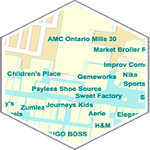

In [ ]:
#search for the traffic analysis group in host gis
host_group = host_gis.groups.search("Traffic")[0]
host_group

In [ ]:
#create a collaboration
description='Data sharing initiative between Dept.' + \
            'of Tranportation and Police of the city of Philadelphia'
host_collab = host_gis.admin.collaborations.create(name='Philly Police Dept. + Dept. of Transport', 
                                                   description=description,
                                                   workspace_name='Philly Police Transport data sharing',
                                                   workspace_description=description,
                                                   portal_group_id=host_group.id,
                                                   host_contact_first_name='Traffic',
                                                   host_contact_last_name='Chief',
                                                   host_contact_email_address='traffic.chief@city.gov',
                                                  access_mode='sendAndReceive')

host_collab

{'collaborationHostPortalId': '44532675-b386-49e9-abe9-fea4a16a5177',
 'config': {'ownerUsername': 'admin'},
 'created': 1502225631271,
 'description': 'Data sharing initiative between Dept.of Tranportation and Police of the city of Philadelphia',
 'id': 'a607c633adb0488992bdcef1f7ba1a18',
 'modified': 1502225631271,
 'name': 'Philly Police Dept. + Dept. of Transport'}

## Step 2: Invite participant GIS to the collaboration
You can invite one or more participants by calling the `invite_participant()` method of the `collaboration` object. At this stage, you specify the workspace id and the privilege each participant has. Note, you can have multiple workspaces within a collaboration.

To call the `invite_participant()` you need to compose a list of dictionaries containing the collaboration ids and the privileges for the participant in each of these workspaces. This pattern allows a participant GIS to be a member of multiple workspaces within the same collaboration, with different permissions to share and receive content in each.

As a response, you get an *invitation* file which you can send the guest GIS in a secure manner. You can call this method multiple times to invite different participants.

In [ ]:
#get the list of workspaces available as part of the collaboration
host_collab.workspaces

[{'collaborationId': 'a607c633adb0488992bdcef1f7ba1a18',
  'config': {'maxItemSizeInMB': 50, 'maxReplicationPackageSizeInMB': 100},
  'created': 1502225631858,
  'description': 'Data sharing initiative between Dept.of Tranportation and Police of the city of Philadelphia',
  'id': '4d1e3e7d44f24fbca49c4f11975e3184',
  'modified': 1502225631858,
  'name': 'Philly Police Transport data sharing',
  'participantGroupLinks': [{'accessMode': 'sendAndReceive',
    'config': {'copyFeatureServiceData': False, 'enableRealtimeSync': True},
    'portalGroupId': 'ee1b101fef7b4fa483c66c54971c6005',
    'portalGroupName': 'Traffic incident analysis',
    'portalId': '44532675-b386-49e9-abe9-fea4a16a5177'}],
  'participantsWithoutGroupLinks': []}]

In [ ]:
#compose the list of collaboration workspaces and the privileges for each
config = [{host_collab.workspaces[0]['id']:'sendAndReceive'}]

#invite the guest GIS and download the invitation file
invite_file = host_collab.invite_participant(config_json= config, expiration=24,
                                             guest_portal_url = "https://guest-portal.company.com/portal",
                                            save_path=r'E:\gis_projects\collab')

#print the path to the invite file
invite_file

'E:\\gis_projects\\collab\\collaboration-dev005223.esri.com.invite'

## Step 3: Accept the invitation at the participant GIS
To accept an invitation, call the `accept_invitation()` method on the `admin.collaborations` object. During this stage, you specify a corresponding contact person in the Guest organization and the invite file, either as a JSON text or as a file on disk. After accepting, you call the `export_invitation()` to download a response file that you can send the administrator of the host GIS in a secure manner.

In [ ]:
guest_gis.admin.collaborations.accept_invitation(first_name='Police', 
                                                 last_name='Chief', 
                                                 email='police.chief@city.gov', 
                                                 invitation_file=invite_file)

{'success': True}

Get the `Collaboration` object created as a result of accepting the invitation

In [ ]:
#get the list of collaborations on the guest GIS and pick the one created earlier
guest_gis.admin.collaborations.list()

[{'collaborationHostPortalId': '44532675-b386-49e9-abe9-fea4a16a5177',
  'config': {'ownerUsername': 'admin'},
  'created': 1502150029661,
  'description': 'auto collaborations',
  'id': '2570cc95b1b2415eb95b84ba2f720506',
  'modified': 1502150029661,
  'name': 'collab_high_level_collab'},
 {'collaborationHostPortalId': '44532675-b386-49e9-abe9-fea4a16a5177',
  'config': {'ownerUsername': 'admin'},
  'created': 1502225679791,
  'description': 'Data sharing initiative between Dept.of Tranportation and Police of the city of Philadelphia',
  'id': 'a607c633adb0488992bdcef1f7ba1a18',
  'modified': 1502225679791,
  'name': 'Philly Police Dept. + Dept. of Transport'}]

In [ ]:
#in this case, there are two collaborations and the second is the relevant one
guest_collab = guest_gis.admin.collaborations.list()[1]
type(guest_collab)

arcgis.gis.admin._collaboration.Collaboration

#### Export the response file
Now export a response file that can be sent back to the host GIS

In [ ]:
response_file = guest_collab.export_invitation(out_folder = r"E:\gis_projects\collab")
response_file

'E:\\gis_projects\\collab\\collaboration-dev005223.esri.com.response'

## Step 4: Join a group to the collaboration in the guest GIS
After the guest GIS accepts a collaboration from a host, a workspace gets created. You need to add a group to this workspace by calling the `add_group_to_workspace()` method from the `Collaboration` object.

In [ ]:
#first get the list of worksapces in the guest collaboration
guest_collab.workspaces

[{'collaborationId': 'a607c633adb0488992bdcef1f7ba1a18',
  'config': {'maxItemSizeInMB': 50, 'maxReplicationPackageSizeInMB': 100},
  'created': 1502225680547,
  'description': 'Data sharing initiative between Dept.of Tranportation and Police of the city of Philadelphia',
  'id': '4d1e3e7d44f24fbca49c4f11975e3184',
  'modified': 1502225680547,
  'name': 'Philly Police Transport data sharing',
  'participantGroupLinks': [{'accessMode': 'sendAndReceive',
    'config': {},
    'portalId': '44532675-b386-49e9-abe9-fea4a16a5177'}],
  'participantsWithoutGroupLinks': [{'accessMode': 'sendAndReceive',
    'config': {},
    'portalId': '9f9a15e0-97c9-4020-8e0b-906ba628668a'}]}]

<Group title:"Crime analysis" owner:admin>
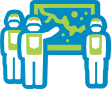

In [ ]:
#search for the crime analysis group in the guest portal
guest_group = guest_gis.groups.search("crime")[0]
guest_group

In [ ]:
guest_collab.add_group_to_workspace(portal_group = guest_group, 
                                    workspace= guest_collab.workspaces[0])

{'success': True}

## Step 5: Accept the collaboration response at the host GIS
Since the guest GIS accepted the collaboration request and created a response file, to finish the loop, the host GIS has to accept this response. You can do this by calling the `import_invitation_response()` method from the `Collaboration` object of the host GIS.

In [ ]:
host_collab.import_invitation_response(response_file)

{'success': True}

## Shortcut to establish collaborations in a single step
While the above 5 steps provide a lot of options to customize collaborations, administrators can establish collaborations easily by calling the `collaborate_with()` method off `admin.collaborations` object. This shortcut internally performs thes 5 steps and is suitable if you are the administrator on both the organizations and want to create a collaboration using the default values.

This method accepts a `name` and a `description`. It creates a new group using the format `grp_ + <name>` in both the host and the guest and a workspace called `wksp + <name>` in both the host and guest GIS. The default privilege is `sendAndRecieve`.

To establish a collaboration, simply call:

In [ ]:
host_gis.admin.collaborations.collaborate_with(guest_gis = guest_gis,
                                               collaboration_name='Transport_PD_data_sharing', 
                                               collaboration_description='Data sharing initiative between' + \
                                               'the transport and Police departments')

True

You can verify the collaboration by querying the host and guest GIS

In [ ]:
print("Collaborations on host GIS")
for collab in host_gis.admin.collaborations.list():
    print(collab.name)

print("-----------------------------")
print("Collaborations on guest GIS")
for collab in guest_gis.admin.collaborations.list():
    print(collab.name)

Collaborations on host GIS
collab_high_level_collab
Philly Police Dept. + Dept. of Transport
collab_Transport_PD_data_sharing
-----------------------------
Collaborations on guest GIS
collab_high_level_collab
Philly Police Dept. + Dept. of Transport
collab_Transport_PD_data_sharing


## Use a collaboration
You can share content with other collaborators by sharing it to the group associated with your collaboration workspace. See [Share content with collaboration groups for details](http://server.arcgis.com/en/portal/latest/use/share-content-with-collaboration-participants.htm).